# Dealing with Bias and Fairness in AI/Data Science Systems
## AAAI 2021 Hands-on Tutorial
### Pedro Saleiro, Kit Rodolfa, Rayid Ghani

# <font color=red>Exploring Bias Reduction Strategies</font>

## 1. Install dependencies, import packages and data
This is needed every time you open this notebook in **colab** to install dependencies

In [250]:
# packages not installed in colab
!pip install aequitas==0.42.0
!pip install fairlearn==0.4.6


import yaml
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import fairlearn
import warnings
warnings.filterwarnings("ignore")
sns.set() 
DPI = 200
DATAPATH = 'https://github.com/dssg/fairness_tutorial/raw/master/data/'

## What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. 

As described earlier, the goal here is to select top 1000 project submissions that are likely to not get funded in order to prioritize resource allocation. That corresponds to the metric **Precision at top 1000**.

### <font color=red>We audited the "best" model at precision at top 1000 and found that it has disparities for True Positive Rate for all attributes that we care about (poverty_level of the school, sex, and school_location_type)</font>


## What do we want to do now?

1. Could we have picked a different model that was similar enough in "precision at top 1000" but less biased?


## Load predictions, labels, and attributes for all models that were built to audit

We have trained 400 models using random sampling of hyperparameters for the following algorithms: RandomForest, Logistic Regression, MLP and LightGBM. The `evals_df` contains a table with the performance metrics for each model on the holdout test set.

In [251]:
evals_df = pd.read_csv(DATAPATH +'split2_evals.csv.gz', compression='gzip')
# Let's sort the models by Precision at top 1000 predicted positives (our performance metric of interest for this case study)
evals_df.sort_values('model_precision', ascending = False)
evals_df.head(10)

,model_precision,model_classpath,hyperparameters,model_uuid,predictions_uuid,target_pp,matrix_type,matrix_start_date,matrix_end_date
0,0.552,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,test,2012-12-01,2013-01-31
1,0.551,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,test,2012-12-01,2013-01-31
2,0.550,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",8823d053f9fbe6c34efdae3a2f24c39c,5e78e49f70fac0193eaadb8513428f23,1000,test,2012-12-01,2013-01-31
3,0.549,lightgbm.LGBMClassifier,"{""n_jobs"": -1, ""max_depth"": 2, ""num_leaves"": 5...",ffc7abef4fe933b0f0cfed63d5d03910,f04edad1446642411085e84271898506,1000,test,2012-12-01,2013-01-31
4,0.548,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",110d892ce37127a79d7c6e0eac9a5d13,09092f371176a13cddca59bac20da4fd,1000,test,2012-12-01,2013-01-31
5,0.547,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""entropy"", ""max_de...",856a91cee8d3e81d35b0c7578d8459cb,dc9f61602f5c90b70aa8e6040eaf2972,1000,test,2012-12-01,2013-01-31
6,0.544,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",9d582bc500e1d99e0949ec9d35ae8eb3,d3de1db6eed5cfab17d64d6a13e20c8d,1000,test,2012-12-01,2013-01-31
7,0.544,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",bcc12af1a0ae151aabd5238e3a4fb242,eb671681600d5304fce6873004c61c50,1000,test,2012-12-01,2013-01-31
8,0.543,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",7fa15e633491add493d45e9dc7440315,5bd60c3f912e6d62b9acf7b3a56ae803,1000,test,2012-12-01,2013-01-31
9,0.543,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""entropy"", ""max_de...",da8d97ec5529f435974e238b1b29cf7f,4cd560dcb70bfe5bfef3ad1628eaba8a,1000,test,2012-12-01,2013-01-31


### Spot-check the model with highest precision at 1000 to see what type it is

In [252]:
print('Highest precision model classpath and hyperparameters: \n\n' , evals_df['model_classpath'][0], '\n', evals_df['hyperparameters'][0])

Highest precision model classpath and hyperparameters: 

 sklearn.ensemble.RandomForestClassifier 
 {"n_jobs": -1, "criterion": "gini", "max_depth": 30, "max_features": "sqrt", "n_estimators": 87, "random_state": 213500298, "min_samples_leaf": 44, "min_samples_split": 3}


## Load pre-computed Aequitas audit results 

The `aequitas_df` contains a table with the bias audit results for the 400 models for all the attributes we care about (we pre-selected the metrics of interest for this tutorial). 

In [253]:
aequitas_df = pd.read_csv(DATAPATH + 'split2_aequitas.csv.gz', compression='gzip')
aequitas_df.head(10)

,model_uuid,predictions_uuid,k,attribute_name,attribute_value,tpr,tpr_disparity,tpr_ref_group_value,pp,tp,group_label_pos,prev,group_size,matrix_type,matrix_start_date,matrix_end_date
0,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,suburban_rural,0.139156,1.000000,suburban_rural,626,333,2393,0.367814,6506,test,2012-12-01,2013-01-31
1,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,urban,0.042674,0.306665,suburban_rural,192,120,2812,0.308502,9115,test,2012-12-01,2013-01-31
2,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,teacher_sex,female,0.102390,3.370670,male,951,527,5147,0.341019,15093,test,2012-12-01,2013-01-31
3,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,poverty_level,lower,0.137859,1.000000,lower,753,394,2858,0.370976,7704,test,2012-12-01,2013-01-31
4,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,poverty_level,highest,0.050771,0.368285,lower,247,158,3112,0.312043,9973,test,2012-12-01,2013-01-31
5,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,teacher_sex,male,0.030377,1.000000,male,49,25,823,0.318498,2584,test,2012-12-01,2013-01-31
6,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,poverty_level,lower,0.149405,1.000000,lower,805,427,2858,0.370976,7704,test,2012-12-01,2013-01-31
7,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,poverty_level,highest,0.039846,0.266696,lower,195,124,3112,0.312043,9973,test,2012-12-01,2013-01-31
8,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,teacher_sex,female,0.101613,2.986684,male,944,523,5147,0.341019,15093,test,2012-12-01,2013-01-31
9,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,teacher_sex,male,0.034022,1.000000,male,56,28,823,0.318498,2584,test,2012-12-01,2013-01-31


Combining the `evals_df` with the `aequitas_df` allow us to get a clearer picture how the different models compare with each other in both performance and bias of our groups of interest. 

The `create_scatter_disparity_performance` method will help us to easily plot the 400 models bias-performance tradeoffs and it's going to be used throughout the notebook.

In [254]:
def create_scatter_disparity_performance(evals_df, aequitas_df,  attr_col, group_name, 
                                         performance_col='model_precision', bias_metric='tpr', flip_disparity=False, 
                                         mitigated_tags=[], mitigated_bdfs=[], mitigated_performances=[], ylim=None):
    disparity_df = aequitas_df.loc[(aequitas_df['attribute_name']==attr_col) & (aequitas_df['attribute_value']==group_name)].copy()
    disparity_metric = bias_metric + '_disparity'
    scatter_schema = ['model_uuid', performance_col, 'attribute_name', 'attribute_value', bias_metric, disparity_metric, 'model_tag']
    if flip_disparity:
        disparity_df[disparity_metric]= disparity_df.apply(lambda x: 1/x[disparity_metric] , axis=1)
    scatter = pd.merge(evals_df, disparity_df, how='left', on=['model_uuid'], left_index=True, sort=True, copy=True)
    scatter = scatter[['model_uuid', performance_col, 'attribute_name', 'attribute_value', bias_metric, disparity_metric]].copy()
    scatter['model_tag'] = 'Other Models'
    scatter.sort_values('model_precision', ascending = False, inplace=True, ignore_index=True)
    scatter['model_tag'] = scatter.apply(lambda x: 'Highest Precision at 1000' if int(x.name) < 1 else x['model_tag'], axis=1)
    mitigated_points = []
    scatter_final = pd.DataFrame()
    if mitigated_bdfs and mitigated_performances:
        for i in range(len(mitigated_bdfs)):
            if not mitigated_bdfs[i].empty and mitigated_performances[i] !=None:
                mitigated_bdfs[i][performance_col] = mitigated_performances[i]
                mitigated_bdfs[i]['model_tag'] = mitigated_tags[i]
                new_disparity_df = mitigated_bdfs[i].loc[(mitigated_bdfs[i]['attribute_name']==attr_col) & (mitigated_bdfs[i]['attribute_value']==group_name)].copy()
                if flip_disparity:
                    new_disparity_df[disparity_metric]= new_disparity_df.apply(lambda x: 1/x[disparity_metric] , axis=1)
                scatter_new = new_disparity_df[[c for c in new_disparity_df.columns if c in scatter_schema]].copy()
                mitigated_points.append(scatter_new)
        scatter_final = pd.concat(mitigated_points , axis=0)

    ax = sns.scatterplot(
        x='model_precision', y=disparity_metric, hue='model_tag',
        data=scatter,
        alpha=0.4, s=20, palette = np.array(sns.color_palette()[0:2])


    )
    if not scatter_final.empty:
        ax1 = sns.scatterplot(
            x='model_precision', y=disparity_metric, hue='model_tag',
            data=scatter_final,
            alpha = 0.95, s=20,  palette = np.array(sns.color_palette()[2:3] + sns.color_palette()[4:])
        )

    if ylim:
        plt.ylim(0, 10)
    flip_placeholder = 'Flipped' if flip_disparity else ''
    ax.set_title('{} {} vs.{} for {}:{}'.format(flip_placeholder, disparity_metric, performance_col, attr_col,group_name ), y=1., fontsize='xx-small')
    #plt.gcf().set_size_inches((4, 3))
    plt.legend(loc='upper left', fontsize='xx-small', prop={'size': 5})
    plt.gcf().set_dpi(DPI)
    plt.show() 




## Let's see if we could have picked a better model for fairness in Poverty Level

Each point in the scatterplot represents a model. We highlight the model we picked before (highest global performance).

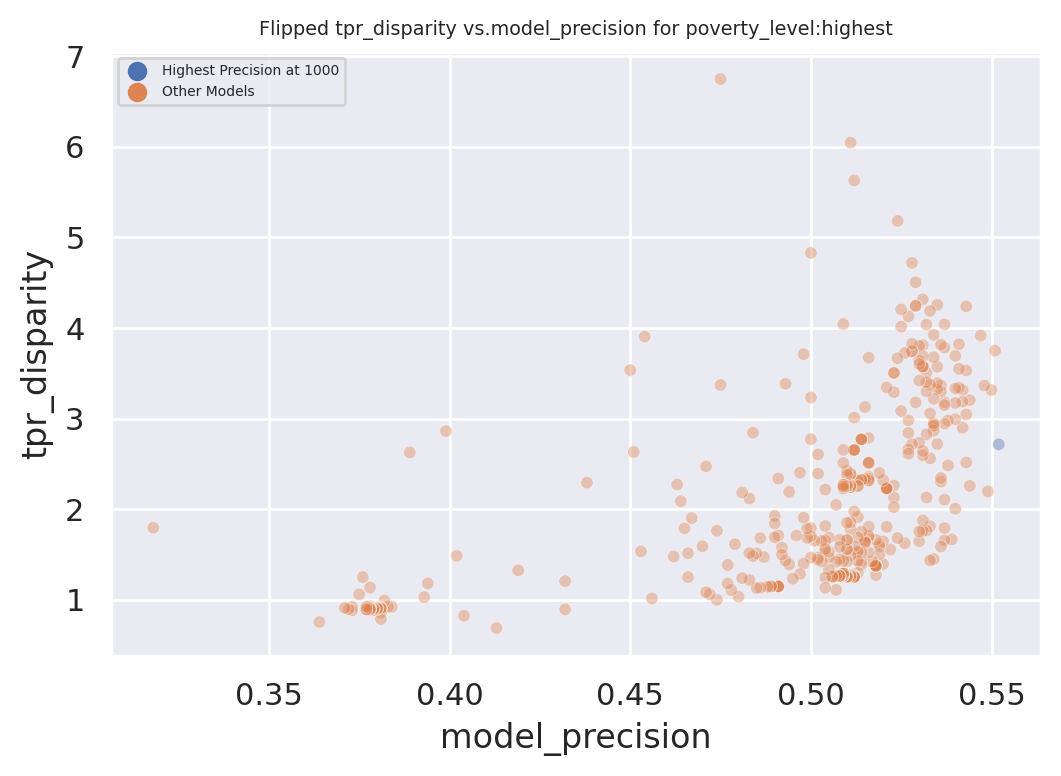

In [255]:
create_scatter_disparity_performance(evals_df, aequitas_df, 'poverty_level', 'highest', flip_disparity=True )

## Let's see if we could have picked a better model for fairness in Metro Type


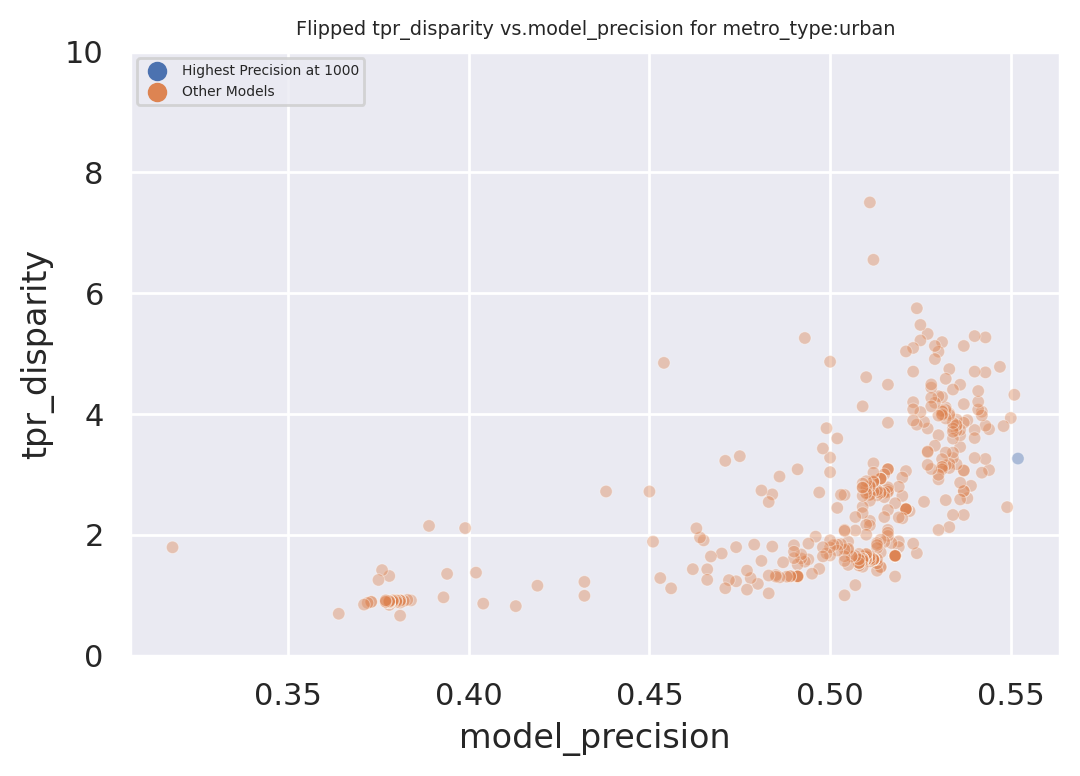

In [256]:
create_scatter_disparity_performance(evals_df, aequitas_df, 'metro_type', 'urban', flip_disparity=True, ylim=10 )

## Let's see if we could have picked a better model for fairness in Teacher sex



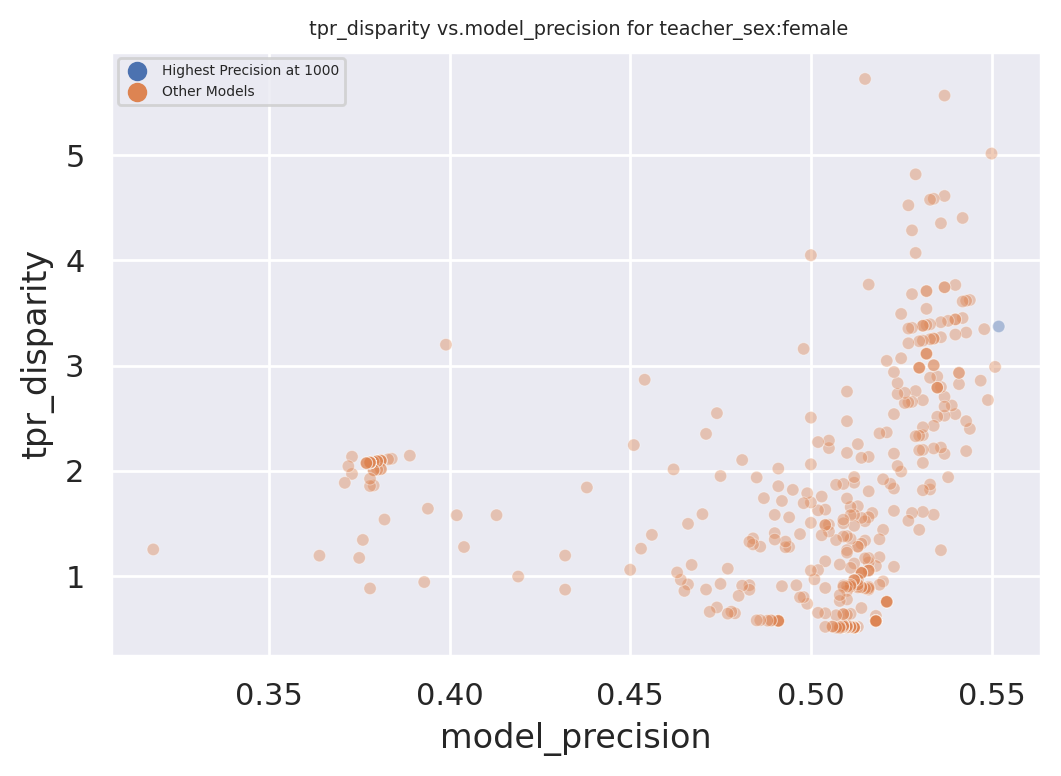

In [257]:
create_scatter_disparity_performance(evals_df, aequitas_df, 'teacher_sex', 'female', flip_disparity=False )

# Bias Reduction Strategies
We will try a few different bias reduction strategies now and compare the audit results with the original models

1. Re-Sampling
2. Regularization (using Fairlearn package)
3. Post-hoc adjustment


## <font color="red">Bias Reduction Strategy 1: Re-Sampling</font>
### Can resampling approaches help improve the fairness of our models?

1. Load data
2. Look at training data distributions
3. Try Resampling in a few different ways
4. Rebuild model(s) on resampled training data
5. Predict on the test set
6. Audit for Bias and Compare

### What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. We then used these results to pick a "best" model in terms of performance on the "accuracy" metric we care about: **Precision at the top 1000** (corresponding to our goal of selecting 1000 project submissions that are most likely to not get funded in order to prioritize resource allocation).

When we audited this selected model with Aequitas, however, we found biases across many attributes, including the poverty level of the schools. Here, we explore a methods based on resampling to reduce this bias in the selected model.

### Load data

In [258]:
traindf = pd.read_csv(DATAPATH + 'train_20120501_20120801.csv.gz', compression='gzip')
testdf = pd.read_csv(DATAPATH + 'test_20121201_20130201.csv.gz', compression='gzip')
train_attrdf = pd.read_csv(DATAPATH + 'train_20120501_20120801_protected.csv.gz', compression='gzip')
test_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')


In [259]:
traindf.shape

(16790, 113)

### Load pre-built models and predictions

The `evals_df` contains a table with the performance metrics for each model on the holdout test set.

In [260]:
evals_df = pd.read_csv(DATAPATH +'split2_evals.csv.gz', compression='gzip')
# Let's sort the models by Precision at top 1000 predicted positives (our performance metric of interest for this case study)
evals_df.sort_values('model_precision', ascending = False)

,model_precision,model_classpath,hyperparameters,model_uuid,predictions_uuid,target_pp,matrix_type,matrix_start_date,matrix_end_date
0,0.552,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,test,2012-12-01,2013-01-31
1,0.551,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,test,2012-12-01,2013-01-31
2,0.550,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",8823d053f9fbe6c34efdae3a2f24c39c,5e78e49f70fac0193eaadb8513428f23,1000,test,2012-12-01,2013-01-31
3,0.549,lightgbm.LGBMClassifier,"{""n_jobs"": -1, ""max_depth"": 2, ""num_leaves"": 5...",ffc7abef4fe933b0f0cfed63d5d03910,f04edad1446642411085e84271898506,1000,test,2012-12-01,2013-01-31
4,0.548,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",110d892ce37127a79d7c6e0eac9a5d13,09092f371176a13cddca59bac20da4fd,1000,test,2012-12-01,2013-01-31
...,...,...,...,...,...,...,...,...,...
395,0.373,sklearn.neural_network.MLPClassifier,"{""alpha"": 0.00009627719435096597, ""beta_1"": 0....",b52e7837725a5a34544c10297256fc81,6020b409648f794f6f55ed235924afe3,1000,test,2012-12-01,2013-01-31
396,0.372,sklearn.neural_network.MLPClassifier,"{""alpha"": 0.000022779312051721987, ""beta_1"": 0...",e79173c1595bc2ba28edee0c01467fa9,b16ad6b2a7eba2e6ba30c14981ebaf3b,1000,test,2012-12-01,2013-01-31
397,0.371,sklearn.neural_network.MLPClassifier,"{""alpha"": 0.0000629250653559928, ""beta_1"": 0.9...",5423f461c575db9934e52b49c2aabf0f,ca1c9b8e742db3761a660cac81a19102,1000,test,2012-12-01,2013-01-31
398,0.364,lightgbm.LGBMClassifier,"{""n_jobs"": -1, ""max_depth"": 14, ""num_leaves"": ...",853e04831b0a855f22f4bd46b995223c,3e9271171981a27f976a9ef8c739cad0,1000,test,2012-12-01,2013-01-31


### Take a look at the "Best" performing model

In [261]:
print('Highest precision model classpath and hyperparameters: \n\n' , evals_df['model_classpath'][0], '\n', evals_df['hyperparameters'][0])

Highest precision model classpath and hyperparameters: 

 sklearn.ensemble.RandomForestClassifier 
 {"n_jobs": -1, "criterion": "gini", "max_depth": 30, "max_features": "sqrt", "n_estimators": 87, "random_state": 213500298, "min_samples_leaf": 44, "min_samples_split": 3}


In [262]:
#Let's load the hyperparameters of the highest performance model to a dictionary
import ast
hyperparameters= ast.literal_eval(evals_df['hyperparameters'][0])

In [263]:
# Since the model with highest performance is a RandomForestClassifier let's create a classifier with the fetched hyperparameters
rf = RandomForestClassifier(**hyperparameters)

In [264]:
rf.__dict__

{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'min_impurity_split',
  'random_state',
  'ccp_alpha'),
 'max_depth': 30,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 44,
 'min_samples_split': 3,
 'min_weight_fra

### Defining label, group of interest and reference group for the attribute column we care about


In [265]:
label_col = 'quickstart_label'
attribute_col = 'poverty_level'

group_of_interest = 'highest'
reference_group = 'lower'

### Look at training data distributions

#### Poverty_level=Highest
label_pos_poverty_highest =  P(poverty_level=highest | not_funded)

label_neg_poverty_highest =  P(poverty_level=highest | funded)


#### Poverty_level=Lower
label_pos_poverty_lower =  P(poverty_level=lower | not_funded)

label_neg_poverty_lower =  P(poverty_level=lower | funded)


In [266]:
train_attrdf[attribute_col].value_counts()

highest    9448
lower      7342
Name: poverty_level, dtype: int64

In [267]:
def get_group_stats(df, attrdf, label_col, attribute_col, group_name):
    """Calculates group-wise stats: prevalence, group_size, num label pos, num label neg
       Returns: prevalence, group_size, df of group label pos, df of group label neg
    """
    group_size = len(df.loc[attrdf[attribute_col]==group_name])
    label_pos = df.loc[(attrdf[attribute_col]==group_name) & (df[label_col] > 0)].copy()
    label_neg = df.loc[(attrdf[attribute_col]==group_name) & (df[label_col] < 1.0)].copy()
    assert (group_size == len(label_pos) + len(label_neg)), "label pos + label neg is different from group size!"
    prev = len(label_pos) / group_size
    print("{} == '{}'\n\t group size: {} \n\t prevalence: {:.3f}".format(attribute_col,group_name, group_size, prev))
    return prev, group_size, label_pos, label_neg

In [268]:
_ = get_group_stats(traindf, train_attrdf, label_col, attribute_col, group_of_interest)

poverty_level == 'highest'
	 group size: 9448 
	 prevalence: 0.338


In [269]:
_ = get_group_stats(traindf, train_attrdf, label_col, attribute_col, reference_group)

poverty_level == 'lower'
	 group size: 7342 
	 prevalence: 0.426


### What type of disparities do we see in the data distribution here?


1.

2.

3.

4.


















...







In [270]:
print('Recapping the group of interest and reference we defined above: \n\n Attribute: {}\n Group of interest: {}\n Reference Group: {}'.format(attribute_col, group_of_interest, reference_group))

Recapping the group of interest and reference we defined above: 

 Attribute: poverty_level
 Group of interest: highest
 Reference Group: lower


### Let's now try resampling

We can perform three types of resampling:

1. Change the training data such that different poverty levels are distributed more uniformly but keep the distribution of labels the same within each poverty level P(poverty_level = highest) = P (poverty_level=lower)


2. Change the training data such that different poverty levels have more uniform label distributions P(poverty_level = highest | not funded ) = P(poverty_level=lower | not funded)


3. Change both

The following method implements these 3 approaches:

In [271]:
def sample_groups_equal(df, 
                  attrdf, 
                  label_col, 
                  attribute_col, 
                  group_of_interest, 
                  reference_group, 
                  equal_group_prevalence=True, 
                  equal_group_size=False, 
                  random_seed=42):
    print("Input stats for each group:\n")
    prev_a, size_a, lp_a,ln_a = get_group_stats(df, attrdf, label_col, attribute_col, group_of_interest)
    prev_ref, size_ref, lp_ref,ln_ref = get_group_stats(df, attrdf, label_col, attribute_col, reference_group)
    if equal_group_prevalence:
        # create largest possible sample based on prevalence ratio (minimize number of label positives removed)
        # group_prevalence_ratio = prev_group_of_interest / prev_ref_group
        if prev_a < prev_ref:
            # create subsample
            num_lp_a = len(lp_a)
            target_prev = prev_ref
            new_num_ln_a = math.floor((num_lp_a / target_prev) - num_lp_a)
            ln_a = ln_a.sample(n=new_num_ln_a, replace=False, random_state=random_seed)
        elif prev_ref < prev_a:
            # create subsample
            num_lp_ref = len(lp_ref)
            target_prev = prev_a
            new_num_ln_ref = math.floor((num_lp_ref / target_prev) - num_lp_ref)
            ln_ref = ln_ref.sample(n=new_num_ln_ref, replace=False, random_state=random_seed)
    adf = pd.concat([lp_a, ln_a], axis=0)
    refdf = pd.concat([lp_ref, ln_ref], axis=0)
    size_a = len(adf)
    size_ref = len(refdf)
    if equal_group_size:
        # create largest possible sample based on size ratio
        if size_a > size_ref:
            adf = adf.sample(n=size_ref, replace=False, random_state=random_seed)
        elif size_ref > size_a:
            refdf = refdf.sample(n=size_a, replace=False, random_state=random_seed)
    new_traindf = pd.concat([adf, refdf], axis=0)
    print("\n\nNew sample stats for each group:\n")
    _ = get_group_stats(new_traindf, attrdf, label_col, attribute_col, group_of_interest)
    _ = get_group_stats(new_traindf, attrdf, label_col, attribute_col, reference_group)
    return new_traindf

### Let's create 3 new different training dataframes by applying the 3 approaches described above

#### Sampling so we get equal group sizes (randomly undersampling largest group)

In [272]:
new_traindf_1 = sample_groups_equal(traindf, train_attrdf, label_col, attribute_col, group_of_interest, reference_group, equal_group_prevalence=False, equal_group_size=True)

Input stats for each group:

poverty_level == 'highest'
	 group size: 9448 
	 prevalence: 0.338
poverty_level == 'lower'
	 group size: 7342 
	 prevalence: 0.426


New sample stats for each group:

poverty_level == 'highest'
	 group size: 7342 
	 prevalence: 0.338
poverty_level == 'lower'
	 group size: 7342 
	 prevalence: 0.426


#### Sampling so we get equal group prevalence in the two groups (undersampling label negatives of group with lower prevalence)

In [273]:
new_traindf_2 = sample_groups_equal(traindf, train_attrdf, label_col, attribute_col, group_of_interest, reference_group, equal_group_prevalence=True, equal_group_size=False)

Input stats for each group:

poverty_level == 'highest'
	 group size: 9448 
	 prevalence: 0.338
poverty_level == 'lower'
	 group size: 7342 
	 prevalence: 0.426


New sample stats for each group:

poverty_level == 'highest'
	 group size: 7496 
	 prevalence: 0.426
poverty_level == 'lower'
	 group size: 7342 
	 prevalence: 0.426


#### Sampling so we get both equal group prevalence and group sizes in the two groups 

In [274]:
new_traindf_3 = sample_groups_equal(traindf, train_attrdf, label_col, attribute_col, group_of_interest, reference_group, equal_group_prevalence=True, equal_group_size=True)

Input stats for each group:

poverty_level == 'highest'
	 group size: 9448 
	 prevalence: 0.338
poverty_level == 'lower'
	 group size: 7342 
	 prevalence: 0.426


New sample stats for each group:

poverty_level == 'highest'
	 group size: 7342 
	 prevalence: 0.426
poverty_level == 'lower'
	 group size: 7342 
	 prevalence: 0.426


#### Rebuild model for each of the resampled training dataframes and predict on the test set

In [275]:
def retrain_and_test(model, label_col, new_traindf, testdf):
    y_train = new_traindf[label_col].values
    model.fit(new_traindf.drop(['entity_id','as_of_date',label_col], axis = 1), y_train)
    y_pred = model.predict_proba(testdf.drop(['entity_id','as_of_date',label_col], axis = 1))[:,1]
    new_preds = testdf[['entity_id','as_of_date',label_col]].copy()
    new_preds['predict_proba'] = y_pred
    new_preds = new_preds.sort_values('predict_proba', ascending = False).reset_index(drop=True).copy()
    new_preds['score'] = new_preds.apply(lambda x: 1.0 if int(x.name)  < 1000 else 0.0, axis=1)
    return new_preds

In [276]:
new_preds_1 = retrain_and_test(rf, label_col, new_traindf_1, testdf)
new_preds_2 = retrain_and_test(rf, label_col, new_traindf_2, testdf)
new_preds_3 = retrain_and_test(rf, label_col, new_traindf_3, testdf)


#### Calculate precision at 1000 for each of the 3 approaches

In [277]:

print('Approach 1 Model Precision: ', new_preds_1[new_preds_1['score'] > 0][label_col].sum() / 1000)
print('Approach 2 Model Precision: ', new_preds_2[new_preds_2['score'] > 0][label_col].sum() / 1000)
print('Approach 3 Model Precision: ', new_preds_3[new_preds_3['score'] > 0][label_col].sum() / 1000)

Approach 1 Model Precision:  0.536
Approach 2 Model Precision:  0.563
Approach 3 Model Precision:  0.543


## Before and After: Run Aequitas


Let's define an audit util method to use throghout the notebook when audit different models.

In [278]:
def aequitas_audit(input_df, ref_groups_dict):
    g = Group()
    b = Bias()
    xtab, _ = g.get_crosstabs(input_df[['score','label_value'] + list(ref_groups_dict.keys())].copy())
    bdf = b.get_disparity_predefined_groups(xtab, input_df, ref_groups_dict)
    return bdf


#### Define the configurations for running the bias audits:

    - a dictionary for reference groups in the format attribute:group
    - the metrics of interest
    - the fairness threshold (the ratio of each group value compared to reference group on a given metric)

In [279]:
ref_groups_dict={'poverty_level':'lower', 'metro_type':'suburban_rural', 'teacher_sex':'male'}
attributes = ref_groups_dict.keys()
metrics = ['tpr']
fairness_threshold = 1.3

For reference, let's start with looking at the "best" model we chose in terms of overall precision at 1,000:

#### Now let's start with loading the predictions from the "best" model chosen earlier

In [280]:
id_col='entity_id'
date_col = 'as_of_date'
top_k= 1000
old_preds = pd.read_csv(DATAPATH + 'predictions_c598fbe93f4c218ac7d325fb478598f1.csv.gz', compression='gzip')
old_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

old_df = pd.merge(old_preds, old_attrdf, how='left', on=[id_col, date_col], left_index=True, right_index=False, sort=True, copy=True)

old_df = old_df.sort_values('predict_proba', ascending=False)
old_df = old_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas

# create a "score" column with the predicted class (named "score" for use with Aequitas below)
old_df['score'] = old_df.apply(lambda x: 1.0 if x.name in old_df.head(top_k).index.tolist() else 0, axis=1)

### Before: Run Aequitas for the "best" model chosen earlier

In [281]:
bdf_old = aequitas_audit(old_df, ref_groups_dict)

get_disparity_predefined_group()


In [282]:
ap.disparity(bdf_old, metrics, 'poverty_level', fairness_threshold)

alt.LayerChart(...)

### After: Audit for Bias for the new mitigated models  (keeping the attributes, reference groups, bias metric, and tolerance the same as before)

#### Approach 1: Equalizing group sizes

In [283]:
df_1 = pd.merge(new_preds_1, test_attrdf, how='left', on=['entity_id','as_of_date'], left_index=True, right_index=False, sort=True, copy=True)
df_1 = df_1.rename(columns = {label_col:'label_value'})
bdf_1 = aequitas_audit(df_1, ref_groups_dict)


get_disparity_predefined_group()


In [284]:
ap.disparity(bdf_1, metrics, 'poverty_level', fairness_threshold = 1.3)

alt.LayerChart(...)

In [285]:
ap.disparity(bdf_1, metrics, 'metro_type', fairness_threshold = 1.3)

alt.LayerChart(...)

In [286]:
ap.disparity(bdf_1, metrics, 'teacher_sex', fairness_threshold = 1.3)

alt.LayerChart(...)

#### Approach 2: Equalizing group prevalence

In [287]:
df_2 = pd.merge(new_preds_2, test_attrdf, how='left', on=['entity_id','as_of_date'], left_index=True, right_index=False, sort=True, copy=True)
df_2 = df_2.rename(columns = {label_col:'label_value'})
bdf_2 = aequitas_audit(df_2, ref_groups_dict)


get_disparity_predefined_group()


In [288]:
ap.disparity(bdf_2, metrics, 'poverty_level', fairness_threshold = 1.3)

alt.LayerChart(...)

In [289]:
ap.disparity(bdf_2, metrics, 'metro_type', fairness_threshold = 1.3)

alt.LayerChart(...)

In [290]:
ap.disparity(bdf_2, metrics, 'teacher_sex', fairness_threshold = 1.3)

alt.LayerChart(...)

#### Approach 3: Equalizing both group prevalence and group sizes

In [291]:
df_3 = pd.merge(new_preds_3, test_attrdf, how='left', on=['entity_id','as_of_date'], left_index=True, right_index=False, sort=True, copy=True)
df_3 = df_3.rename(columns = {label_col:'label_value'})
bdf_3 = aequitas_audit(df_3, ref_groups_dict)


get_disparity_predefined_group()


In [292]:
ap.disparity(bdf_3, metrics, 'poverty_level', fairness_threshold = 1.3)

alt.LayerChart(...)

In [293]:
ap.disparity(bdf_3, metrics, 'metro_type', fairness_threshold = 1.3)

alt.LayerChart(...)

In [294]:
ap.disparity(bdf_3, metrics, 'teacher_sex', fairness_threshold = 1.3)

alt.LayerChart(...)

### Adding to the model selection (tradeoff) graph

Finally, let's look at how this new option stacks up against what we plotted in our model selection process:

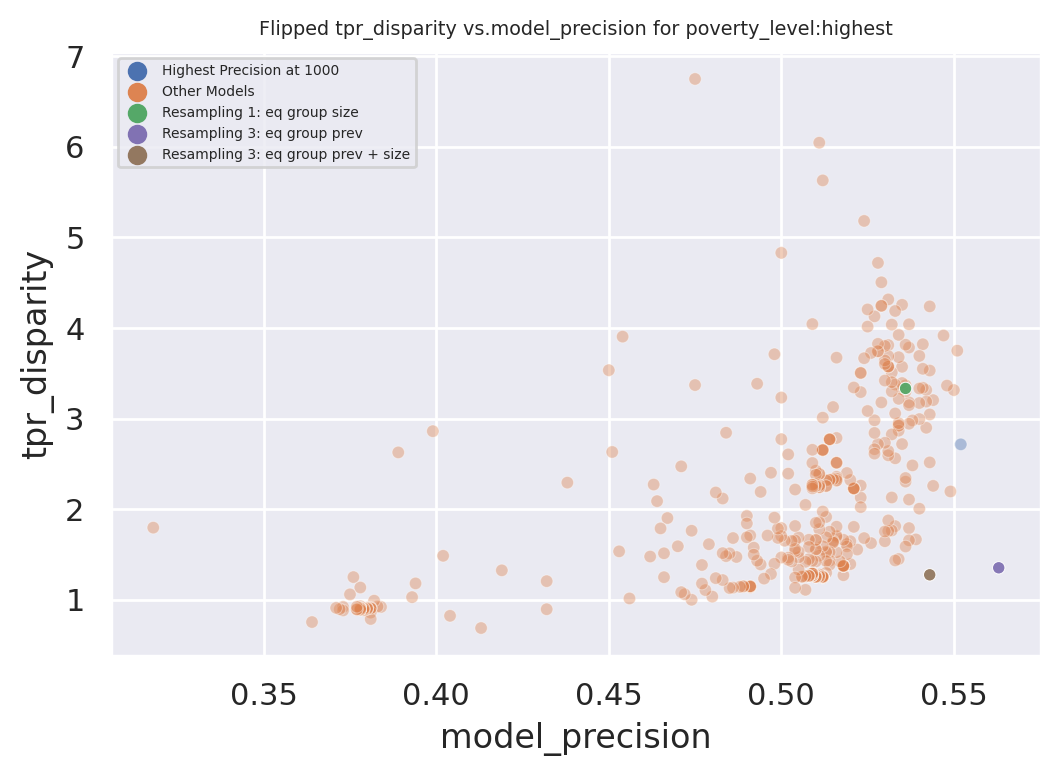

In [295]:
mitigated_precision_1 = df_1.loc[df_1['score']==1]['label_value'].mean()
mitigated_precision_2 = df_2.loc[df_2['score']==1]['label_value'].mean()
mitigated_precision_3 = df_3.loc[df_3['score']==1]['label_value'].mean()

plot_configs = {
    'evals_df':evals_df, 
    'aequitas_df':aequitas_df,
    'attr_col':'poverty_level', 
    'group_name':'highest',
    'performance_col':'model_precision',
    'bias_metric':'tpr', 
    'flip_disparity':True, 
    'mitigated_tags':['Resampling 1: eq group size','Resampling 3: eq group prev', 'Resampling 3: eq group prev + size'],
    'mitigated_bdfs':[bdf_1, bdf_2, bdf_3],
    'mitigated_performances':[mitigated_precision_1, mitigated_precision_2, mitigated_precision_3],
    'ylim':None
}
create_scatter_disparity_performance(**plot_configs)

## <font color=red>Bias Reduction Strategy 2: Regularization (using Fairlearn package)</font>
### <font color=red>In-Processing Fairness Improvement</font>

### 1. Install dependencies, import packages and data
This is needed every time you open this notebook in colab to install dependencies

In [296]:
# Let's use the methods 
from fairlearn.reductions import ExponentiatedGradient, GridSearch, DemographicParity, TruePositiveRateDifference
from fairlearn.metrics import selection_rate_group_summary

### What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. We then used these results to pick a "best" model in terms of performance on the "accuracy" metric we care about: **Precision at the top 1000** (corresponding to our goal of selecting 1000 project submissions that are most likely to not get funded in order to prioritize resource allocation).

When we audited this selected model with Aequitas, however, we found biases across many attributes, including the poverty level of the schools. Here, we explore a method of using in-processing to train a fairness-aware classifier in order to reduce this bias.

### <font color=green>FairLearn - a reductions approach</font>

[Paper](https://arxiv.org/pdf/1803.02453.pdf): _A Reductions Approach to Fair Classification_, 2018

> We present a systematic approach for achievingfairness in a binary classification setting. Whilewe focus on two well-known quantitative defini-tions of fairness, our approach encompasses manyother  previously  studied  definitions  as  specialcases. The key idea is to __reduce fair classification__ to a __sequence  of  cost-sensitive__  classification problems, whose solutions yield a randomized classifier with the __lowest (empirical) error__ subject to  the  __desired  constraints__.   We  introduce  two reductions that work for any representation of the cost-sensitive  classifier  and  compare  favorably to prior baselines on a variety of data sets, while overcoming several of their disadvantages.

[FairLearn Documentation](https://fairlearn.github.io/user_guide/mitigation.html#id17)



### TLDR; 

- This approach poses Fair Learning as a constrained optimization problem: minimize the empirical error, subject to linear constraints of the fairness (e.g., TPR difference, demographic parity).
- Solve the constrained optimization as a __cost-sensitive__ classification problem.
- Obtain a __randomized classifier__, which implies they will create multiple base estimators.


### Load train and test matrices as well as protected attributes

In [297]:
traindf = pd.read_csv(DATAPATH + 'train_20120501_20120801.csv.gz', compression='gzip')
testdf = pd.read_csv(DATAPATH + 'test_20121201_20130201.csv.gz', compression='gzip')
train_attrdf = pd.read_csv(DATAPATH + 'train_20120501_20120801_protected.csv.gz', compression='gzip')
test_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

### Set up some parameters we'll need below and create matrices

In [298]:
label_col = 'quickstart_label'
date_col = 'as_of_date'
id_col = 'entity_id'
attr_col = 'poverty_level'
exclude_cols = [label_col, date_col, id_col]

top_k = 1000

# aequitas parameters
metrics = ['tpr']
disparity_threshold = 1.3
protected_attribute_ref_group = {attr_col:'lower'}


X_train, y_train, A_train = traindf[[c for c in traindf.columns if c not in exclude_cols]].values, traindf[label_col].values, train_attrdf[[attr_col]]
X_test,   y_test,   A_test   = testdf[[c for c in testdf.columns if c not in exclude_cols]].values,   testdf[label_col].values  , test_attrdf[[attr_col]]


### Setting up a fairness-improving classifier

To account fairness during model training, we'll use the **Exponentiated Gradient** provided by the `fairlearn` module.


Its hyperparameters are: 
- `estimator`: an estimator that implements the methods `fit(X, y, sample_weight)` and `predict(X)`.
- `constraints`: fairness constraints.
- `eps: float`: fairness threshold, i.e., how much constraint violation we support (defaults to 0.01). 
- `T: int`: maximum number of iterations (defaults to 50).
- `nu: float`: convergence threshold for duality gap (defaults to None).
- `eta_0: float`: initial learning rate (defaults to 2).
- `run_linprog_step: bool`: whether to apply saddle point optimization to the convex hull of classifiers obtained so far, after each exponentiated gradient step (defaults to True).

In [299]:
# NOTE: Exponentiated Gradient has a stoachastic component
np.random.seed(0)

Notice that we're using `TruePositiveRateDifference` for our fairness constraint here since we care about equalizing **recall** (aka **tpr** aka **equality of opportunity**) across our subgroups:

In [300]:
# Step 1. Define the constraint
constraint = TruePositiveRateDifference()

# Step 2. Define the base estimator (any estimator providing 'fit' and 'predict')
# Note: we could have used other algorithm such as logistic regression or random forest
base_estimator = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10)

# Step 3. Define the bias reducer algorithm you want to apply
bias_reducer = ExponentiatedGradient(base_estimator, constraint, T=50)

# Step 4. Fit the data (and provide the sensitive attributes)
bias_reducer.fit(X_train, y_train, sensitive_features=A_train)

### Predict on our test set

In [301]:
# Step 5. Use the mitigator to make predictions 
y_pred_4 = bias_reducer.predict(X_test)
new_preds_4 = testdf[['entity_id','as_of_date','quickstart_label']].copy()
new_preds_4['score'] = y_pred_4

### Look at the output
Notice that unlike many classifiers, the `ExponentiatedGradient` doesn't have a method for predicting a continuous score, just predicted classes of 0 or 1. How many projects did this model predict are at risk of going unfunded (that is, predicted class of 1)?

In [302]:
new_preds_4['score'].value_counts()

0    11128
1     6549
Name: score, dtype: int64

It looks like about 6,500 projects are predicted as being at risk of going unfunded by this classifier, but unfortunately our program is resource-constrained and can only help 1,000 of them. At this point, if we wanted to pick out the 1,000 highest-risk projects (subject to our fairness constraint), we're a bit stuck: **the classifier doesn't give us any method for distinguishing higher-risk vs lower-risk projects!**

Given this limitation, we might posit that a reasonable approach would be to pick 1,000 projects to intervene with from among these 6,500. Let's see what would happen if we did that...

### Before and After: Run Aequitas

For reference, let's start with looking at the "best" model we chose in terms of overall precision at 1,000:

#### Load the predictions from the "best" model chosen earlier

In [303]:
old_preds = pd.read_csv(DATAPATH + 'predictions_c598fbe93f4c218ac7d325fb478598f1.csv.gz', compression='gzip')
old_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

old_df = pd.merge(old_preds, old_attrdf, how='left', on=[id_col, date_col], left_index=True, right_index=False, sort=True, copy=True)

old_df = old_df.sort_values('predict_proba', ascending=False)
old_df = old_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas

# create a "score" column with the predicted class (named "score" for use with Aequitas below)
old_df['score'] = old_df.apply(lambda x: 1.0 if x.name in old_df.head(top_k).index.tolist() else 0, axis=1)

#### Before: Run Aequitas for the "best" model chosen earlier

In [304]:
def aequitas_audit(input_df, ref_groups_dict):
    g = Group()
    b = Bias()
    xtab, _ = g.get_crosstabs(input_df[['score','label_value'] + list(ref_groups_dict.keys())].copy())
    bdf = b.get_disparity_predefined_groups(xtab, input_df, ref_groups_dict)
    return bdf


In [305]:
bdf_old = aequitas_audit(old_df, protected_attribute_ref_group)

ap.disparity(bdf_old, metrics, attr_col, fairness_threshold=disparity_threshold)

get_disparity_predefined_group()


alt.LayerChart(...)

#### After: Run Aequitas for the new, fairness-aware model

Remember here that we would choose 1,000 at random from the 6,500 with predicted class 1, so the expected value for the recall disparity of this randomly-selected set would just be the value of full set (that is, the recall of each subgroup would, on average, be proportionally lower in the sub-sample):

In [306]:
df_4 = pd.merge(new_preds_4, test_attrdf, how='left', on=['entity_id','as_of_date'], left_index=True, right_index=False, sort=True, copy=True)
df_4 = df_4.rename(columns = {label_col:'label_value'})

bdf_4 = aequitas_audit(df_4, protected_attribute_ref_group)

ap.disparity(bdf_4, metrics, attr_col, fairness_threshold=disparity_threshold)

get_disparity_predefined_group()


alt.LayerChart(...)

That looks pretty good! The new model appears to have reduced the disparity across poverty levels considerably relative to what we saw when training a model without a fairness constraint and choosing based on precision alone.

However, the natural question here is where there is a fairness-accuracy trade-off here: What cost did we incur in terms of model performance, that is overall precision?

#### Precision of the "best" model chosen earlier

In [307]:
old_df.loc[old_df['score']==1]['label_value'].mean()

0.552

#### Precision of the new, fairness-aware model

As above, we would be sampling from the 6,500 down to 1,000 but the expected value of precision in this sample would just be the mean label value in the full population:

In [308]:
df_4.loc[df_4['score']==1]['label_value'].mean()

0.4083066116964422

So, compared to the old model, this method has resulted in **quite a large trade-off in model performance to acheive fairness**. This is certainly in part a result of the lack of flexibility in the method not allowing us to provide a score threshold or top k size that we're interested in equalizing our fairness metric around and instead using a built-in threshold that yields 6,500 predicted positives when we're only able to intervene on 1,000. Unfortunately, this sort of inflexibility appears to be a common attribute of many in-processing methods available today.

For context, the overall base rate (`df['label_value'].mean()`) is 0.338, so the drop-off in precision here is about half way from our previous model to simply choosing at random.

### Adding to model selection

Finally, let's look at how this new option stacks up against what we plotted in our model selection process:

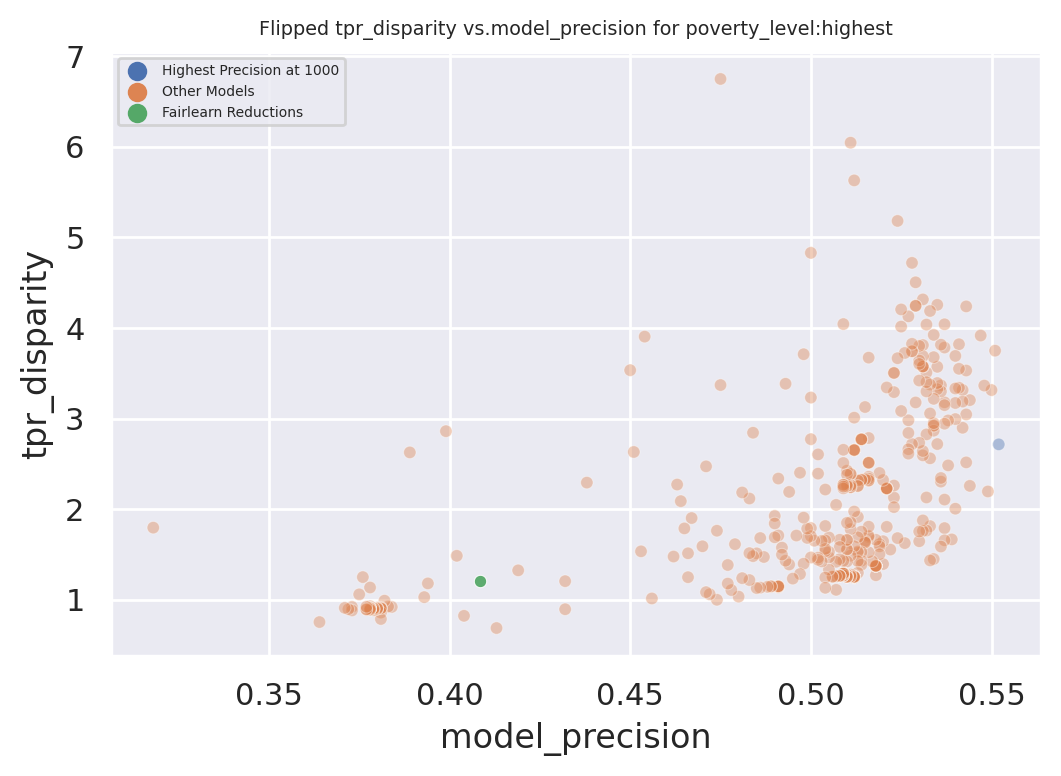

In [309]:
mitigated_precision_4 = df_4.loc[df_4['score']==1]['label_value'].mean()
plot_configs = {
    'evals_df':evals_df, 
    'aequitas_df':aequitas_df,
    'attr_col':'poverty_level', 
    'group_name':'highest',
    'performance_col':'model_precision',
    'bias_metric':'tpr', 
    'flip_disparity':True, 
    'mitigated_tags':['Fairlearn Reductions'],
    'mitigated_bdfs':[bdf_4], 
    'mitigated_performances':[mitigated_precision_4], 
    'ylim':None
}
create_scatter_disparity_performance(**plot_configs)

## <font color=red>Bias Reduction Strategy 3: Post-Hoc Disparity Mitigation</font>

### What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. We then used these results to pick a "best" model in terms of performance on the "accuracy" metric we care about: **Precision at the top 1000** (corresponding to our goal of selecting 1000 project submissions that are most likely to not get funded in order to prioritize resource allocation).

When we audited this selected model with Aequitas, however, we found biases across many attributes, including the poverty level of the schools. Here, we explore a method of using post-hoc disparity mitigation to reduce this bias in the selected model.

### <font color=green>Intro to Post-Hoc Bias Mitigation</font>

![Diagram of Post-Hoc Adjustments](post_hoc_adj.png "Post-Hoc Adjustments")

One approach to improving the fairness of our model is to make post-hoc adjustments to the thresholds used for each subgroup to choose the 1,000 projects on which to intervene. Because our fairness metric here (**recall** aka **tpr** aka **equality of opportunity**) is monatonically increasing with the depth of the score, we should be able to find score thresholds for each subgroup that will equalize this metric across the groups, subject to the constraint that we want to choose a total of 1,000 projects for our intervation.

In short, here's how this will work (see the references below for a more detailed discussion):
1. Train the model as usual on a training set, predict scores on a test set
2. Split this test set by subgroups on our protected attribute (here, poverty level)
3. Sort each subgroup by score and calculate the cumulative tpr/recall up to and including each row in the set, storing this "rolling within-subgroup recall" value
4. Recombine the subgroups, and sort the entire set by this new value
5. Take the top 1,000 projects from this re-ordered list and use it to calculate "top k" sizes for each subgroup that equalize recall
6. Then, on a future test set, use these calculated subgroup list sizes to assess the impact of disparities and overall precision

References:
- Hardt, et al, [Equality of Opportunity in Supervised Learning](http://papers.nips.cc/paper/6373-equality-of-opportunity-in-supervised-learning)
- Rodolfa, et al, [Case Study: Predictive Fairness to Reduce Misdemeanor Recidivism Through Social Service Interventions](https://dl.acm.org/doi/abs/10.1145/3351095.3372863?casa_token=zc196JJrqkkAAAAA:bPmqmKrA91esJhIxHPT4K1crWWb5JGcflVFDkTgODctMzLpUX50_56Kyyh4NJ2GTd_QSydqhNpjT)

### Load the train, test, and protected attributes from the first split

In [310]:
split1_traindf = pd.read_csv(DATAPATH + 'train_20111101_20120201.csv.gz', compression='gzip')
split1_testdf = pd.read_csv(DATAPATH + 'test_20120601_20120801.csv.gz', compression='gzip')
split1_attrdf = pd.read_csv(DATAPATH + 'test_20120601_20120801_protected.csv.gz', compression='gzip')

Let's just take a quick look at the data to make sure it makes sense:

In [311]:
split1_traindf.head()

,entity_id,as_of_date,project_features_entity_id_all_grade_level_Grades35_sum,project_features_entity_id_all_grade_level_Grades68_sum,project_features_entity_id_all_grade_level_Grades912_sum,project_features_entity_id_all_grade_level_GradesPreK2_sum,project_features_entity_id_all_grade_level__NULL_sum,project_features_entity_id_all_resource_type_Books_sum,project_features_entity_id_all_resource_type_Other_sum,project_features_entity_id_all_resource_type_Supplies_sum,project_features_entity_id_all_resource_type_Technology_sum,project_features_entity_id_all_resource_type_Trips_sum,project_features_entity_id_all_resource_type_Visitors_sum,project_features_entity_id_all_resource_type__NULL_sum,project_features_entity_id_all_school_metro__NULL_sum,project_features_entity_id_all_school_metro_rural_sum,project_features_entity_id_all_school_metro_suburban_sum,project_features_entity_id_all_school_metro_urban_sum,project_features_entity_id_all_school_state_AK_sum,project_features_entity_id_all_school_state_AL_sum,project_features_entity_id_all_school_state_AR_sum,project_features_entity_id_all_school_state_AZ_sum,project_features_entity_id_all_school_state_CA_sum,project_features_entity_id_all_school_state_CO_sum,project_features_entity_id_all_school_state_CT_sum,project_features_entity_id_all_school_state_DC_sum,project_features_entity_id_all_school_state_DE_sum,project_features_entity_id_all_school_state_FL_sum,project_features_entity_id_all_school_state_GA_sum,project_features_entity_id_all_school_state_HI_sum,project_features_entity_id_all_school_state_IA_sum,project_features_entity_id_all_school_state_ID_sum,project_features_entity_id_all_school_state_IL_sum,project_features_entity_id_all_school_state_IN_sum,project_features_entity_id_all_school_state_KS_sum,project_features_entity_id_all_school_state_KY_sum,project_features_entity_id_all_school_state_LA_sum,project_features_entity_id_all_school_state_La_sum,project_features_entity_id_all_school_state_MA_sum,project_features_entity_id_all_school_state_MD_sum,...,project_features_entity_id_all_teacher_prefix_Mr_sum,project_features_entity_id_all_teacher_prefix_Mrs_sum,project_features_entity_id_all_teacher_prefix_Ms_sum,project_features_entity_id_all_teacher_prefix__NULL_sum,project_features_entity_id_all_teacher_prefix__sum,project_features_entity_id_all_total_asking_price_sum,project_features_entity_id_all_total_asking_price_imp,resources_features_entity_id_all_item_quantity_sum,resources_features_entity_id_all_item_quantity_imp,essay_features_entity_id_all_lengthessayint_sum,essay_features_entity_id_all_lengthessayint_imp,donation_features_entity_id_all_district_avg_donations_1yr_sum,donation_features_entity_id_all_district_avg_donations_1yr_imp,donation_features_entity_id_all_district_avg_donations_2yr_sum,donation_features_entity_id_all_district_avg_donations_2yr_imp,donation_features_entity_id_all_district_funding_rate_1yr_sum,donation_features_entity_id_all_district_funding_rate_1yr_imp,donation_features_entity_id_all_district_funding_rate_2yr_sum,donation_features_entity_id_all_district_funding_rate_2yr_imp,donation_features_entity_id_all_teacher_avg_donations_1yr_sum,donation_features_entity_id_all_teacher_avg_donations_1yr_imp,donation_features_entity_id_all_teacher_avg_donations_2yr_sum,donation_features_entity_id_all_teacher_avg_donations_2yr_imp,donation_features_entity_id_all_teacher_funding_rate_1yr_sum,donation_features_entity_id_all_teacher_funding_rate_1yr_imp,donation_features_entity_id_all_teacher_funding_rate_2yr_sum,donation_features_entity_id_all_teacher_funding_rate_2yr_imp,donation_features_entity_id_all_zip_avg_donations_1yr_sum,donation_features_entity_id_all_zip_avg_donations_1yr_imp,donation_features_entity_id_all_zip_avg_donations_2yr_sum,donation_features_entity_id_all_zip_avg_donations_2yr_imp,donation_features_entity_id_all_zip_funding_rate_1yr_sum,donation_features_entity_id_all_zip_funding_rate_1yr_imp,donation_features_entity_id_all_zip_funding_r

### Set up some parameters we'll need below

Note that the classifier type and hyperparameters here are from the best-performing model we chose above based on precision on the top 1000.

In [312]:
hyperparameters = {
    'criterion': 'gini',
    'max_depth': 30,
    'max_features': 'sqrt',
    'min_samples_leaf': 44,
    'min_samples_split': 3,
    'n_estimators': 87,
    'n_jobs': -1,
    'random_state': 213500298
}
clf = RandomForestClassifier(**hyperparameters)

top_k = 1000

label_col = 'quickstart_label'
entity_col = 'entity_id'
date_col = 'as_of_date'
exclude_cols = [label_col, entity_col, date_col] # columns to exclude from the X matrices for the classifier

protected_attribute_col = 'poverty_level'

# Parameters for Aequitas

metrics = ['tpr']
disparity_threshold = 1.3
protected_attribute_ref_group = {protected_attribute_col:'lower'}


### Train the model and predict on the test set

In [313]:
# train
y_train = split1_traindf[label_col].values
clf.fit(split1_traindf.drop(exclude_cols, axis = 1), y_train)

# test set predictions
split1_preds = split1_testdf[[entity_col, date_col, label_col]].copy()
split1_preds['predict_proba'] = clf.predict_proba(split1_testdf.drop(exclude_cols, axis = 1))[:,1]

Let's take a quick look at the predictions to make sure they look good:

In [314]:
split1_preds.head()

,entity_id,as_of_date,quickstart_label,predict_proba
0,246363,1338591600000,1.0,0.382485
1,246362,1338591600000,1.0,0.188013
2,246361,1338591600000,0.0,0.398983
3,246360,1338591600000,0.0,0.422042
4,246359,1338591600000,1.0,0.403111


### Combine predictions with protected attributes

In [315]:
df = pd.merge(split1_preds, split1_attrdf, how='left', on=[entity_col,date_col], left_index=True, right_index=False, sort=True, copy=True)

### Sort by score, then split by protected attribute (poverty level)

In [316]:
protected_attribute_groups = df[protected_attribute_col].unique()

In [317]:
df = df.sort_values('predict_proba', ascending=False)
subgroup_dfs = []
for grp in protected_attribute_groups:
    subgroup_dfs.append(df[df[protected_attribute_col]==grp].copy())

### Calculate within-subgroup cumulative recall

Here, we calculate the recall up to and including each row within the highest-poverty and lower-poverty subsets of the test set. Doing this allows us to recombine and sort the sets in a way that will let find recall-equalizing "top k" list sizes for each subgroup.

In [318]:
for subgrp_df in subgroup_dfs:
    subgrp_df['cumsum_recall'] = subgrp_df[label_col].cumsum() / subgrp_df[label_col].sum()

### Recombine the subgroup sets and sort by this cumulative recall

In [319]:
recall_df = pd.concat(subgroup_dfs, axis=0).sort_values('cumsum_recall', ascending=True)

### Find subgroup sizes, holding the overall list size (1000) constant

Now we can simply threshold this re-sorted list by `top_k` (here, 1000) to identify how many individuals from each group we should apply in the future.

Notice here that each subgroup will still be ordered by their predicted score, but the scores will no longer be perfectly ordered across subgroups.

In [320]:
new_pp = recall_df.head(top_k).copy()
new_pp.tail()

,entity_id,as_of_date,quickstart_label,predict_proba,poverty_level,teacher_sex,metro_type,cumsum_recall
9401,236962,1343343600000,0.0,0.423424,highest,female,urban,0.137341
9809,236827,1343430000000,1.0,0.470249,lower,female,suburban_rural,0.137405
4857,241717,1341183600000,1.0,0.423386,highest,female,suburban_rural,0.137780
1610,245042,1339455600000,0.0,0.470204,lower,female,suburban_rural,0.137882
10611,236358,1343516400000,1.0,0.470228,lower,female,suburban_rural,0.137882


In [321]:
new_pp[protected_attribute_col].value_counts()

highest    554
lower      446
Name: poverty_level, dtype: int64

Let's just store this to re-use below:

In [322]:
subgroup_k = {} 
for grp in protected_attribute_groups:
  subgroup_k[grp] = new_pp[protected_attribute_col].value_counts()[grp]

### Apply these subgroup-specific sizes to future test set data

Now we have calculated the number of projects we need to select from each poverty level, we can apply these to the most recent split to assess how well this method reduces the recall disparities we saw initially and whether this has any impact on the overall precision of the model.

### Load the predictions and protected attributes from the future test set

Note that the predictions here correspond to the same model + hyperparameters we specified above

In [323]:
split2_preds = pd.read_csv(DATAPATH + 'predictions_c598fbe93f4c218ac7d325fb478598f1.csv.gz', compression='gzip')
split2_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

df2 = pd.merge(split2_preds, split2_attrdf, how='left', on=[entity_col, date_col], left_index=True, right_index=False, sort=True, copy=True)

Take a quick look to make sure the data loaded without any issue:

In [324]:
df2.head()

,entity_id,as_of_date,quickstart_label,predict_proba,poverty_level,teacher_sex,metro_type
17310,119,1359504000000,0.0,0.364484,lower,female,suburban_rural
15801,120,1359158400000,0.0,0.347160,highest,female,unknown
14694,121,1358812800000,1.0,0.503259,lower,female,suburban_rural
14226,122,1358726400000,0.0,0.442060,lower,female,unknown
14227,123,1358726400000,0.0,0.325577,lower,female,urban


### Split the test set by poverty level to apply the thresholds

In [325]:
df2 = df2.sort_values('predict_proba', ascending=False)
new_subgroup_dfs = {}
for grp in protected_attribute_groups:
    new_subgroup_dfs[grp] = df2[df2[protected_attribute_col]==grp].copy()

### Choose the number of projects from each subgroup found above

Notice here that we're choosing the "top k" individuals within each subgroup based on their predicted score -- in a deployment, we wouldn't know the true labels to calculate recall values, which is why we had to go one step back in time to find these group sizes.

In [326]:
pp_dfs = []
for grp in protected_attribute_groups:
    pp_dfs.append(new_subgroup_dfs[grp].head(subgroup_k[grp]))

### Recombine and create a predicted class label for this resulting set
That is, 1,000 projects with a label 1 chosen by this process and 0 otherwise

In [327]:
new_pp2 = pd.concat(pp_dfs, axis=0).sort_values('predict_proba', ascending=True)

mitigated_df = df2.copy()
mitigated_df = mitigated_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas

# create a "score" column with the predicted class (named "score" for use with Aequitas below)
mitigated_df['score'] = mitigated_df.apply(lambda x: 1.0 if x.name in new_pp2.index.tolist() else 0, axis=1)

for comparison, let's also look at the unmitigated result again...

In [328]:
unadjusted_df = df2.sort_values('predict_proba', ascending=False).copy()
unadjusted_df = unadjusted_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas

# create a "score" column with the predicted class (named "score" for use with Aequitas below)
unadjusted_df['score'] = unadjusted_df.apply(lambda x: 1.0 if x.name in unadjusted_df.head(top_k).index.tolist() else 0, axis=1)

### Running Aequitas - Before and After

#### For the original score, without post-hoc adjustment for equity

In [329]:
bdf_unadjusted = aequitas_audit(unadjusted_df, protected_attribute_ref_group)
ap.disparity(bdf_unadjusted, metrics, protected_attribute_col, fairness_threshold=disparity_threshold)

get_disparity_predefined_group()


alt.LayerChart(...)

#### For the score, with post-hoc disparity mitigation

In [330]:
bdf_mitigated = aequitas_audit(mitigated_df, protected_attribute_ref_group)

ap.disparity(bdf_mitigated, metrics, protected_attribute_col, fairness_threshold=disparity_threshold)

get_disparity_predefined_group()


alt.LayerChart(...)

So, it looks the post-hoc adjustments have actually manage to mitigate the existing disparity pretty well (perhaps even over-shooting somewhat, though still within our fairness threshold of 1.3).

However, the natural question here is where there is a fairness-accuracy trade-off here: What cost did we incur in terms of model performance, that is overall precision?

#### Before: Precision of the original, unadjusted score

In [331]:
unadjusted_df.loc[unadjusted_df['score']==1]['label_value'].mean()

0.552

#### After: Precision of the new, disparity-mitigated score

In [332]:
mitigated_df.loc[mitigated_df['score']==1]['label_value'].mean()

0.581

Somewhat surprisingly, we actually don't seem to see any trade-off with the disparity mitigation here!

### Adding to the model selection (tradeoff) graph

Finally, let's look at how this new option stacks up against what we plotted in our model selection process:

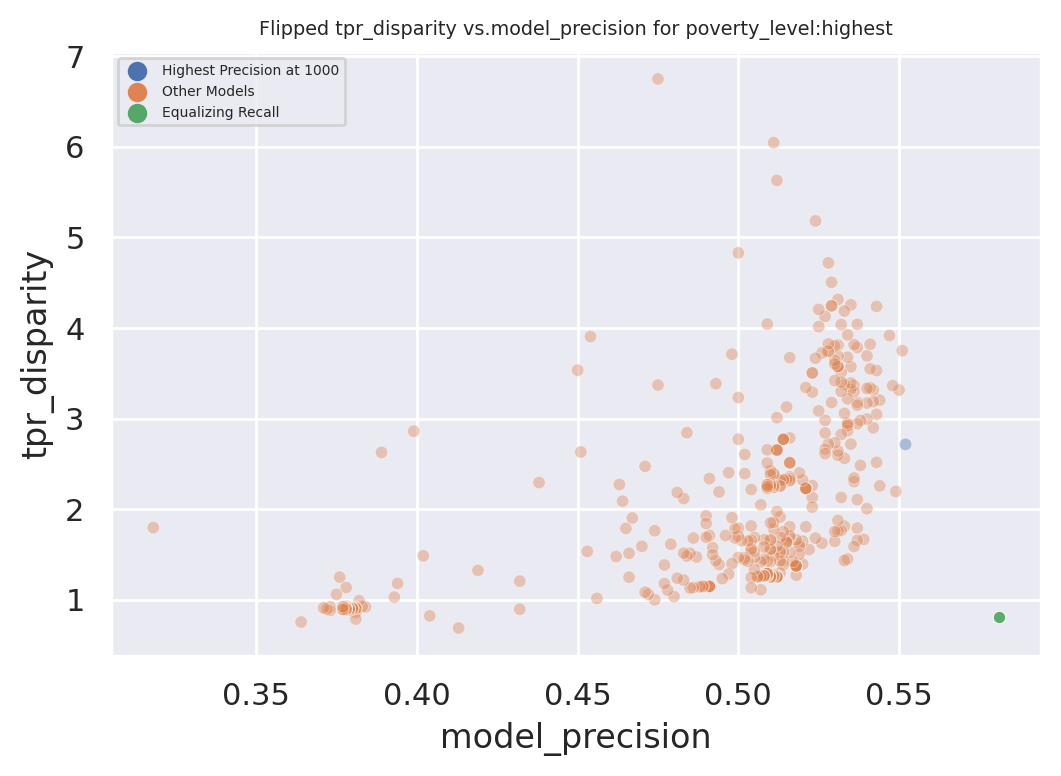

In [333]:
mitigated_precision_5 = mitigated_df.loc[mitigated_df['score']==1]['label_value'].mean()
plot_configs = {
    'evals_df':evals_df, 
    'aequitas_df':aequitas_df,
    'attr_col':'poverty_level', 
    'group_name':'highest',
    'performance_col':'model_precision',
    'bias_metric':'tpr', 
    'flip_disparity':True, 
    'mitigated_tags':['Equalizing Recall'],
    'mitigated_bdfs':[bdf_mitigated], 
    'mitigated_performances':[mitigated_precision_5], 
    'ylim':None
}
create_scatter_disparity_performance(**plot_configs)

# Wrapping-up

## Overview of all mitigation strategies on the model selection (tradeoff) graph


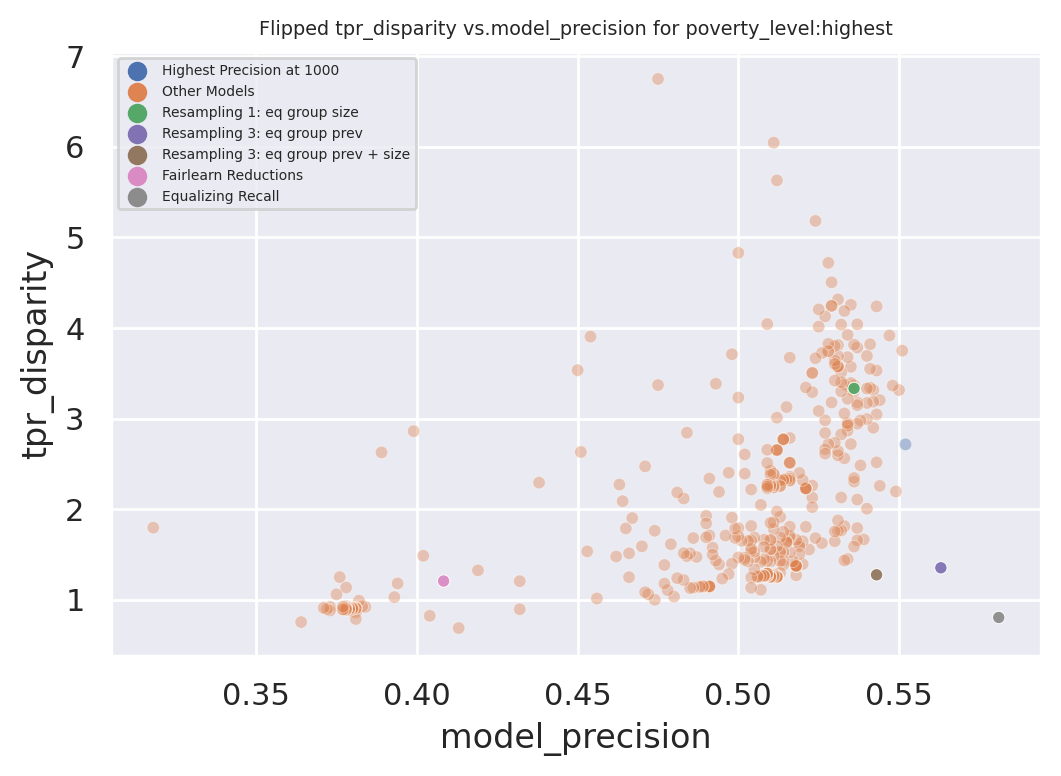

In [334]:
plot_configs = {
    'evals_df':evals_df, 
    'aequitas_df':aequitas_df,
    'attr_col':'poverty_level', 
    'group_name':'highest',
    'performance_col':'model_precision',
    'bias_metric':'tpr', 
    'flip_disparity':True, 
    'mitigated_tags':['Resampling 1: eq group size','Resampling 3: eq group prev', 'Resampling 3: eq group prev + size','Fairlearn Reductions','Equalizing Recall'],
    'mitigated_bdfs':[bdf_1, bdf_2, bdf_3, bdf_4, bdf_mitigated], 
    'mitigated_performances':[mitigated_precision_1, mitigated_precision_2, mitigated_precision_3,mitigated_precision_4, mitigated_precision_5], 
    'ylim':None
}
create_scatter_disparity_performance(**plot_configs)